In [1]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html baseline
import torchaudio
from pathlib import Path
Path('./data/raw').mkdir(parents=True, exist_ok=True)
sc_dataset = torchaudio.datasets.SPEECHCOMMANDS('../data/raw', download=True)

In [2]:
!pip install opencv-python

In [3]:
waveform, sample_rate, label, speaker_id, utterance_number = sc_dataset[8]

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]
            
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

(129, 126, 1)


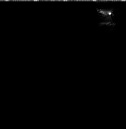

(129, 126, 1)


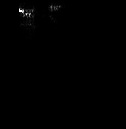

(129, 126, 1)


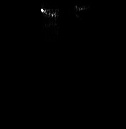

(129, 126, 1)


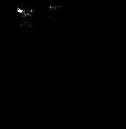

(129, 126, 1)


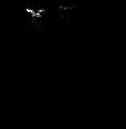

(129, 126, 1)


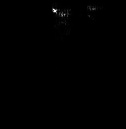

(129, 126, 1)


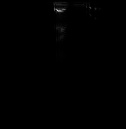

(129, 126, 1)


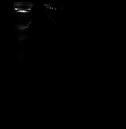

(129, 126, 1)


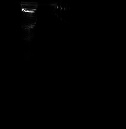

(129, 126, 1)


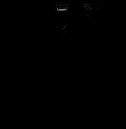

In [4]:
N_SAMPLES = 10
N_FFT = 256
import IPython.display as ipd
import torch
import cv2

for idx in range(N_SAMPLES):
    waveform, sample_rate, label, speaker_id, utterance_id = sc_dataset[idx]
    sound = ipd.Audio(waveform, rate=sample_rate)
    transform = torchaudio.transforms.Spectrogram(n_fft=N_FFT)
    spec = torch.moveaxis(transform(waveform), 0, -1)
    _spec = spec.detach().cpu().numpy()
    _,ret = cv2.imencode('.jpg', _spec) 
    print(_spec.shape)
    img = ipd.Image(data=ret)
    ipd.display(sound)
    ipd.display(img)

In [5]:
import datasets
from datasets import load_dataset

In [6]:
dataset = load_dataset("speech_commands", "v0.02")

Found cached dataset speech_commands (/home/sparkitny/.cache/huggingface/datasets/speech_commands/v0.02/0.2.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da)


  0%|          | 0/3 [00:00<?, ?it/s]

In [46]:
#waveform, sample_rate, label, speaker_id, utterance_number
#audio = dataset['train'][0]['audio']['array']
audio = dataset['train'][0]['audio']
waveform = audio['array']
sample_rate = audio['sampling_rate']
label = dataset['train'][0]['label']
speaker_id = dataset['train'][0]['speaker_id']
utterance_id = dataset['train'][0]['utterance_id']

#file, audio, label, is_unknown, speaker_id, utterance_id = dataset['train'].values()
print(waveform.shape)

(16000,)


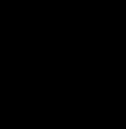

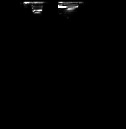

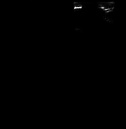

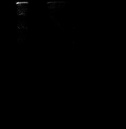

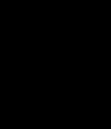

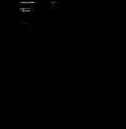

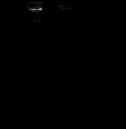

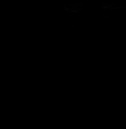

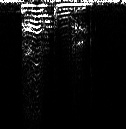

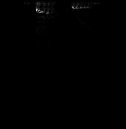

In [59]:
for idx in range(N_SAMPLES):
    audio = dataset['train'][idx]['audio']
    waveform = audio['array']
    sample_rate = audio['sampling_rate']
    label = dataset['train'][idx]['label']
    speaker_id = dataset['train'][idx]['speaker_id']
    utterance_id = dataset['train'][idx]['utterance_id']
    sound = ipd.Audio(waveform, rate=sample_rate)
    transform = torchaudio.transforms.Spectrogram(n_fft=N_FFT)
    spec = transform(torch.from_numpy(waveform)).unsqueeze(axis=0)
    spec = torch.moveaxis(spec, 0, -1)
    _spec = spec.detach().cpu().numpy()
    _,ret = cv2.imencode('.jpg', _spec) 
    #print(_spec.shape)
    img = ipd.Image(data=ret)
    ipd.display(sound)
    ipd.display(img)